Epoch [1/30]
Training Loss: 1.531
Training Accuracy: 53.80%
Training Precision: 0.531, Recall: 0.538, F1-Score: 0.521
Testing Accuracy: 86.60%
Testing Precision: 0.872, Recall: 0.866, F1-Score: 0.861
Best Testing Accuracy: 86.60%
--------------------
Epoch [2/30]
Training Loss: 0.379
Training Accuracy: 87.68%
Training Precision: 0.875, Recall: 0.877, F1-Score: 0.875
Testing Accuracy: 91.74%
Testing Precision: 0.925, Recall: 0.917, F1-Score: 0.915
Best Testing Accuracy: 91.74%
--------------------
Epoch [3/30]
Training Loss: 0.219
Training Accuracy: 92.99%
Training Precision: 0.930, Recall: 0.930, F1-Score: 0.930
Testing Accuracy: 94.62%
Testing Precision: 0.951, Recall: 0.946, F1-Score: 0.945
Best Testing Accuracy: 94.62%
--------------------
Epoch [4/30]
Training Loss: 0.164
Training Accuracy: 94.52%
Training Precision: 0.945, Recall: 0.945, F1-Score: 0.945
Testing Accuracy: 93.86%
Testing Precision: 0.950, Recall: 0.939, F1-Score: 0.939
Best Testing Accuracy: 94.62%
-----------------

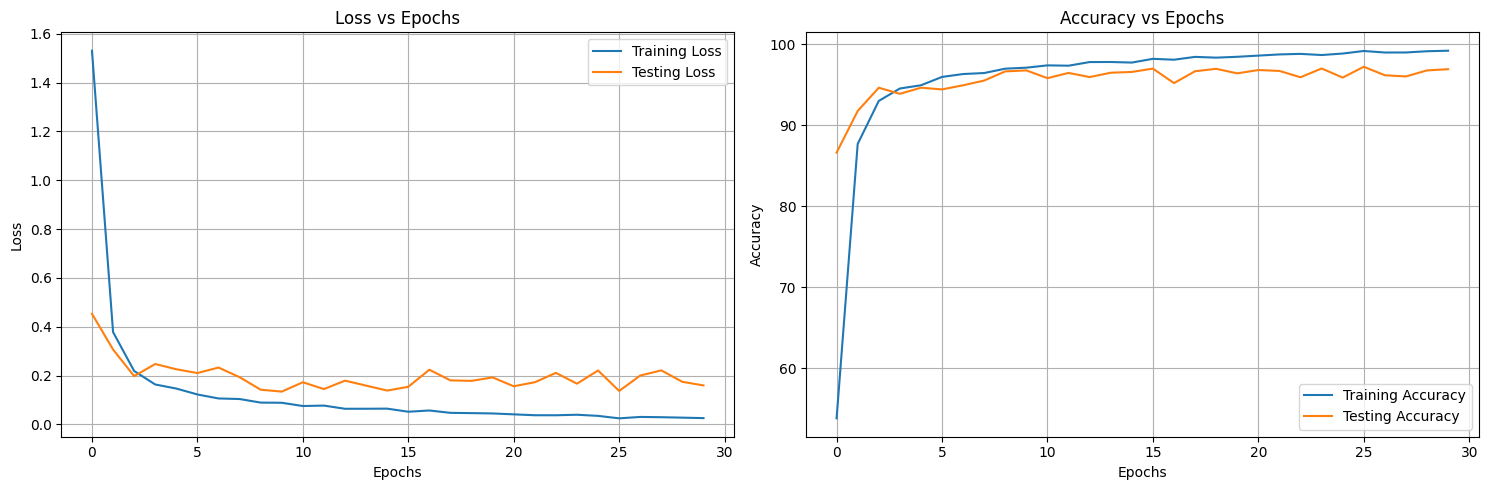

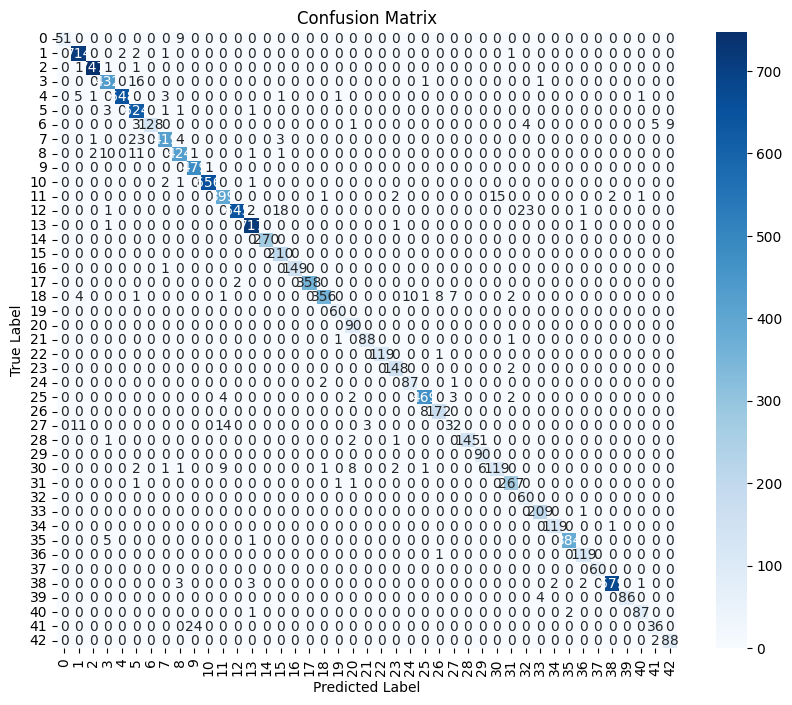

In [5]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import GTSRB
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score


# Set up root directory for the GTSRB dataset
root_dir = '/root/GTSRB'
os.makedirs(root_dir, exist_ok=True)

#Normalize
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to 32x32 pixels
    transforms.ToTensor(),         # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images "for ease of convergence later"
])

# Load the GTSRB training and test datasets
gtsrb_train = GTSRB(root=root_dir, split='train', transform=transform, download=True)
gtsrb_test = GTSRB(root=root_dir, split='test', transform=transform, download=True)

# Load class information
data = pd.read_csv('/root/GTSRB/gtsrb/GT-final_test.csv', sep=';')
num_classes = len(data['ClassId'].unique())

# Create DataLoaders
train_loader = DataLoader(gtsrb_train, batch_size=32, shuffle=True)
test_loader = DataLoader(gtsrb_test, batch_size=32, shuffle=False)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the CNN Model
class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes):
        super(TrafficSignCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Define the model
model = TrafficSignCNN(num_classes=num_classes).to(device)

# Define the loss function
loss_function = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize lists to track metrics
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
epochs = 30
best_test_acc = 0.0

for epoch in range(epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    all_train_preds = []
    all_train_labels = []

    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Append predictions and labels for metrics
        all_train_preds.extend(predicted.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Compute training metrics
    train_precision = precision_score(all_train_labels, all_train_preds, average='weighted', zero_division=0)
    train_recall = recall_score(all_train_labels, all_train_preds, average='weighted', zero_division=0)
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted', zero_division=0)

    # Validation step
    test_running_loss = 0.0
    correct_test = 0
    total_test = 0
    all_test_preds = []
    all_test_labels = []

    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            # Append predictions and labels for metrics
            all_test_preds.extend(predicted.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())

    test_loss = test_running_loss / len(test_loader)
    test_accuracy = 100 * correct_test / total_test
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Compute validation metrics
    test_precision = precision_score(all_test_labels, all_test_preds, average='weighted', zero_division=0)
    test_recall = recall_score(all_test_labels, all_test_preds, average='weighted', zero_division=0)
    test_f1 = f1_score(all_test_labels, all_test_preds, average='weighted', zero_division=0)

    # Save the best model
    if test_accuracy > best_test_acc:
        best_test_acc = test_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'Epoch [{epoch+1}/{epochs}]')
    print(f'Training Loss: {train_loss:.3f}')
    print(f'Training Accuracy: {train_accuracy:.2f}%')
    print(f'Training Precision: {train_precision:.3f}, Recall: {train_recall:.3f}, F1-Score: {train_f1:.3f}')
    print(f'Testing Accuracy: {test_accuracy:.2f}%')
    print(f'Testing Precision: {test_precision:.3f}, Recall: {test_recall:.3f}, F1-Score: {test_f1:.3f}')
    print(f'Best Testing Accuracy: {best_test_acc:.2f}%')
    print('--------------------')

# Graphs for loss vs epoch and accuracy vs epoch
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot losses vs epochs
ax1.plot(train_losses, label='Training Loss')
ax1.plot(test_losses, label='Testing Loss')
ax1.set_title('Loss vs Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracies vs epochs
ax2.plot(train_accuracies, label='Training Accuracy')
ax2.plot(test_accuracies, label='Testing Accuracy')
ax2.set_title('Accuracy vs Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.show()

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(all_test_labels, all_test_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()